In [336]:
import sys
# add path to gp-quadrature
sys.path.append('/Users/colecitrenbaum/Documents/GPs/gp-quadrature')
sys.path.append('/Users/colecitrenbaum/Documents/GPs/gp-quadrature/kernels')
from kernels import SquaredExponential
from vanilla_gp_sampling import sample_bernoulli_gp
from efgpnd import ToeplitzND, compute_convolution_vector_vectorized_dD
import time
import torch
from efgpnd import NUFFT
from cg import ConjugateGradients
from torch import vmap
# from PG_GP import *
from typing import Callable


In [337]:
#default to float64
torch.set_default_dtype(torch.float64)

# --- Parameters ---
n = 1_000  # Number of points
d = 2 # Dimensionality of the input space
true_length_scale =0.2
true_variance = 2.5
dtype = torch.float64  # Use float64 as in the original example
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Use GPU if available
print(f"Using device: {device}")

# --- Generate Input Points ---
# Generate random points in d-dimensional space from -1 to 1
x = torch.rand(n, d, dtype=dtype, device=device) * 2 - 1
y,f = sample_bernoulli_gp(x,length_scale=true_length_scale,variance=true_variance)
rdtype = torch.float64
cdtype = torch.complex128


Using device: cpu
Cholesky succeeded after adding jitter.


# Other data generating

In [338]:
# # --- Parameters ---
# n = 100_000  # Number of points
# d = 2 # Dimensionality of the input space
# dtype = torch.float64  # Use float64 for numerical stability
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# # true_noise_variance = 0.2
# # --- Generate Input Points ---
# # Generate random points in d-dimensional space from -1 to 1
# x = torch.rand(n, d, dtype=dtype, device=device) * 2 - 1
# x = x.to(device, dtype)
# # --- Define the true function ---
# def true_function(x):
#     """
#     A function that works for arbitrary input dimensions
#     x: tensor of shape [n, d] where d is arbitrary
#     """
#     if x.ndim == 1:
#         x = x.unsqueeze(-1)
    
#     d = x.shape[1]
#     result = torch.zeros(x.shape[0], device=x.device, dtype=x.dtype)
    
#     # First term: product of alternating sin/cos across dimensions
#     term1 = torch.ones_like(result)
#     for i in range(d):
#         if i % 2 == 0:
#             term1 = term1 * torch.sin(3 * x[:, i])
#         else:
#             term1 = term1 * torch.cos(4 * x[:, i])
    
#     # Second term: radial basis function centered at alternating points
#     centers = torch.tensor([0.3 if i % 2 == 0 else -0.3 for i in range(d)], 
#                          device=x.device, dtype=x.dtype)
#     squared_dists = torch.sum((x - centers)**2, dim=1)
#     term2 = 0.5 * torch.exp(-squared_dists / 0.3)
    
#     # Third term: periodic function of radius
#     radius_squared = torch.sum(x**2, dim=1)
#     term3 = 0.7 * torch.sin(2 * torch.pi * radius_squared)
    
#     return term1 + term2 + term3

# # --- Generate target values with noise ---
# # Compute true function values
# f = true_function(x)

# y = torch.bernoulli(torch.sigmoid(f)).to(device, dtype)

# print(f"Generated {n} points with shape {x.shape}")
# print(f"Using device: {device}")


In [339]:
import torch
import torch.nn as nn
from typing import List, Iterator, Tuple, Optional, Union
from torch.optim import Adam
from utils.kernels import get_xis
import math



# Setup

In [340]:
class qVariationalParams(nn.Module):
    """Variational parameters for the Polyagamma GP."""
    def __init__(self, n, device=None, dtype=torch.float64):
        """
        Initialize variational parameters.
        
        Args:
            n: Number of data points
            device: torch device
            dtype: torch dtype
        """
        super().__init__()
        self.Delta = nn.Parameter(torch.full((n,), 0.25, dtype=dtype, device=device))
q = qVariationalParams(n)


# All the epsilons here

In [341]:
nufft_eps = 1e-7
cg_tol = 1e-6
eps = 1e-4
trunc_eps = 0.1

In [342]:
rdtype = x.dtype
cdtype = torch.complex128

In [343]:
# kernel = SquaredExponential(dimension = d,init_lengthscale=.1,init_variance=.4)
kernel = SquaredExponential(dimension = d,init_lengthscale=0.2,init_variance=1.25)

x       = x.to(device, rdtype)
y       = y.to(device, rdtype)
if x.ndim == 1:
    x = x.unsqueeze(-1)


In [344]:
def setup_spectral_representation(x, kernel, eps, trunc_eps, device, rdtype, cdtype):
    x0 = x.min(dim=0).values  
    x1 = x.max(dim=0).values  

    if x.ndim == 1:
        x = x.unsqueeze(-1)
    d = x.shape[1]
    domain_lengths = x1 - x0
    L = domain_lengths.max()
    N = x.shape[0]
    xis_1d, h, mtot = get_xis(kernel_obj=kernel, eps=eps, L=L, use_integral=True, l2scaled=False,trunc_eps=trunc_eps)
    grids = torch.meshgrid(*(xis_1d for _ in range(d)), indexing='ij') # makes tensor product Jm 
    xis = torch.stack(grids, dim=-1).view(-1, d) 
    spec_density = kernel.spectral_density(xis).to(dtype=rdtype)
    # spec_density = torch.clamp(spec_density, min=1e-4)
    ws2 = spec_density * h**d
    ws2 = ws2.to(device=device, dtype=cdtype)
    ws = torch.sqrt(ws2) # (mtot**d,1)

    m_conv = (mtot - 1) // 2
    v_kernel = compute_convolution_vector_vectorized_dD(m_conv, x, h).to(dtype=cdtype)
    toeplitz = ToeplitzND(v_kernel, force_pow2=True)   
    spec_grad = kernel.spectral_grad(xis)
    Dprime  = (h**d * spec_grad).to(cdtype)  # (M, 3)
    
    
    return xis, h, mtot, ws, toeplitz, Dprime, spec_density, spec_grad

xis, h, mtot, ws, toeplitz, Dprime, spec_density, spec_grad = setup_spectral_representation(x, kernel, eps,trunc_eps, device, rdtype, cdtype)

ws2 = ws.pow(2)
delta = (q.Delta.to(dtype=cdtype, device=device)).clone()



In [345]:
xis.shape

torch.Size([169, 2])

In [346]:
def naive_kernel(x,xis):
    F_train = torch.exp(2 * math.pi * 1j * torch.matmul(x, xis.T)).to(cdtype)
    return F_train
# F_train = naive_kernel(x,xis)
# W_F_train_star = ws.unsqueeze(1) * F_train.conj().T
# K_train = (F_train * ws) @ W_F_train_star

In [347]:
# Create the NUFFT operator
OUT = (mtot,)*d
nufft_op = NUFFT(x, torch.zeros_like(x), h, nufft_eps, cdtype=cdtype, device=device)

# Define the simplified helper functions
fadj = lambda v: nufft_op.type1(v, out_shape=OUT).reshape(-1)    # F* apply: nonuniform → uniform
fwd = lambda fk: nufft_op.type2(fk, out_shape=OUT)         
fadj_batched = vmap(fadj, in_dims=0, out_dims=0)
fwd_batched = vmap(fwd, in_dims=0, out_dims=0)
fadj_b = fadj_batched       # F apply:  uniform → nonuniform

/Users/colecitrenbaum/myenv/lib/python3.13/site-packages/torch/_tensor.py:1218: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)


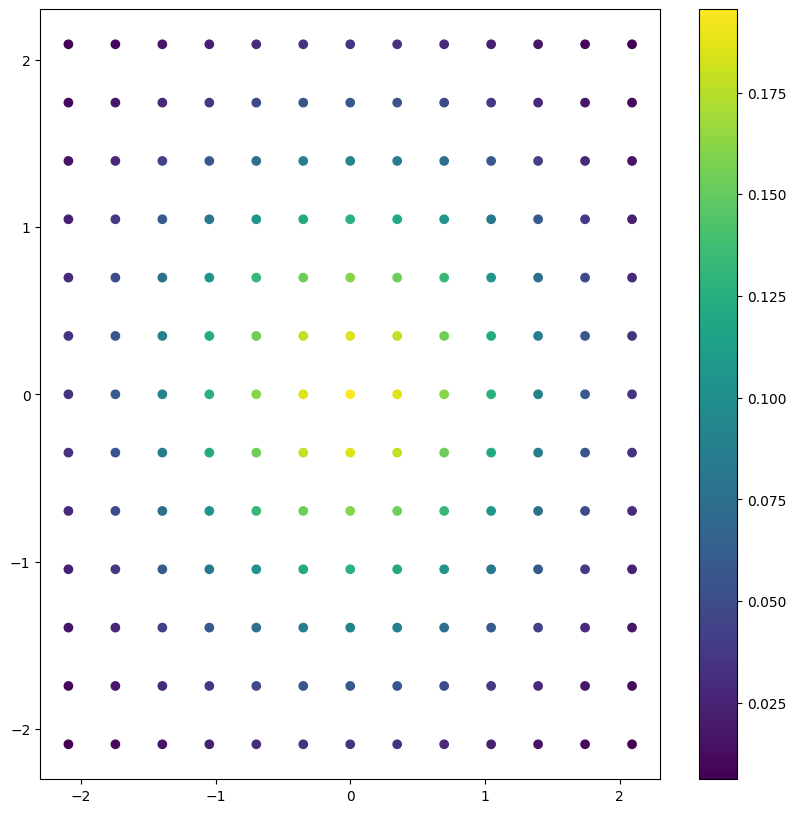

In [348]:
# plot ws in 2d wrt xis 
if d==2:
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10,10))
    plt.scatter(xis[:,0], xis[:,1], c=ws, cmap='viridis')
    plt.colorbar()
    plt.show()


In [349]:
1/ws2

tensor([2.6359e+04+0.j, 9.1647e+03+0.j, 3.8612e+03+0.j, 1.9713e+03+0.j, 1.2195e+03+0.j,
        9.1425e+02+0.j, 8.3053e+02+0.j, 9.1425e+02+0.j, 1.2195e+03+0.j, 1.9713e+03+0.j,
        3.8612e+03+0.j, 9.1647e+03+0.j, 2.6359e+04+0.j, 9.1647e+03+0.j, 3.1864e+03+0.j,
        1.3425e+03+0.j, 6.8539e+02+0.j, 4.2402e+02+0.j, 3.1787e+02+0.j, 2.8876e+02+0.j,
        3.1787e+02+0.j, 4.2402e+02+0.j, 6.8539e+02+0.j, 1.3425e+03+0.j, 3.1864e+03+0.j,
        9.1647e+03+0.j, 3.8612e+03+0.j, 1.3425e+03+0.j, 5.6561e+02+0.j, 2.8876e+02+0.j,
        1.7864e+02+0.j, 1.3392e+02+0.j, 1.2166e+02+0.j, 1.3392e+02+0.j, 1.7864e+02+0.j,
        2.8876e+02+0.j, 5.6561e+02+0.j, 1.3425e+03+0.j, 3.8612e+03+0.j, 1.9713e+03+0.j,
        6.8539e+02+0.j, 2.8876e+02+0.j, 1.4742e+02+0.j, 9.1204e+01+0.j, 6.8373e+01+0.j,
        6.2112e+01+0.j, 6.8373e+01+0.j, 9.1204e+01+0.j, 1.4742e+02+0.j, 2.8876e+02+0.j,
        6.8539e+02+0.j, 1.9713e+03+0.j, 1.2195e+03+0.j, 4.2402e+02+0.j, 1.7864e+02+0.j,
        9.1204e+01+0.j, 5.6424e+

In [350]:
import sys
# add path to gp-quadrature
sys.path.append('/Users/colecitrenbaum/Documents/GPs/gp-quadrature')
sys.path.append('/Users/colecitrenbaum/Documents/GPs/gp-quadrature/kernels')
from kernels import SquaredExponential
from vanilla_gp_sampling import sample_bernoulli_gp
from efgpnd import ToeplitzND, compute_convolution_vector_vectorized_dD
import time
import torch
from efgpnd import NUFFT
from cg import ConjugateGradients
from torch import vmap
import math

                            # (M,)  all equal


# def Fstar_Kinv_z_local(z_batch, toeplitz, ws,cg_tol:float=1e-10):
#     """
#     z_batch: either (n,) or (J,n)
#     returns:
#         alpha = F* K^{-1} z  shape (batch, M)
#         z_f   =       F* z  shape (batch, M)
#     """
#     jitter_val = 1e-
#     # print(jitter_val)
#     toeplitz_jitter = lambda x: toeplitz(x) + jitter_val * x
#     # A_apply = lambda x: toeplitz(ws**2 * x)   # ℝᴹ→ℝᴹ
#     A_apply = lambda x: toeplitz_jitter(ws**2 * x)   # ℝᴹ→ℝᴹ

#     # project into feature‐space
#     if z_batch.ndim == 1:
#         z_batch = z_batch.unsqueeze(0)
#     Zf = fadj_b(z_batch)  # (batch, M)
#     # solve (Toeplitz(ws2··) + jitter·I) x = Zf
#     X = ConjugateGradients(
#         A_apply, Zf, torch.zeros_like(Zf),
#         tol=cg_tol, early_stopping=True
#     ).solve()           # (batch, M)
#     if torch.isnan(X).any():
#         print("X is nan")
#     return X, Zf       # alpha,   F* z



## Using this one 
def D2_Fstar_Kinv_z(z, toeplitz, ws,cg_tol:float=1e-10):
    """
    Actually giving out F^*Kinv z """
    vanilla = False
    jitter_val = 1e-10
    # TODO seems like this version is better for large length scale 

    A_apply = lambda x: ws*toeplitz(ws* x) + jitter_val * x
    if z.ndim == 1:
        z = z.unsqueeze(0)
    fadj_z = fadj_batched(z)
    rhs = ws*fadj_z

    x0 = torch.zeros_like(rhs)

    # M_inv = make_bccb_preconditioner(toeplitz, ws, eps)


    if vanilla:
        A_dense = ws[:, None] * torch.stack([toeplitz(torch.eye(ws.numel(), device=ws.device, dtype=ws.dtype)[:, i])
                                        for i in range(ws.numel())], dim=1) * ws[None, :] \
            + jitter_val * torch.eye(ws.numel(), device=ws.device, dtype=ws.dtype)
        solve   = torch.cholesky_solve(rhs.T, torch.linalg.cholesky(A_dense)).T
    else:
        solve = ConjugateGradients(
            A_apply, rhs, x0,
            tol=cg_tol, early_stopping=False, max_iter = 1000,
            # M_inv_apply=M_inv,
        ).solve()


    return solve/ws, fadj_z


## Alt
    # jitter_val = 1e-10
    # if z.ndim == 1:
    #     z = z.unsqueeze(0)
    # A_apply = lambda x: toeplitz((ws**2) *x) + jitter_val * x
    # rhs = fadj_batched(z)
    # x0 = torch.zeros_like(rhs)
    # solve = ConjugateGradients(
    #     A_apply, rhs, x0,
    #     tol=cg_tol, early_stopping=False,max_iter=1000
    # ).solve()
    # return solve, rhs 






#TODO better for small length scale?
    # A_apply = lambda x: toeplitz(x) + jitter_val * x
    # # print(jitter_val)
    # if z.ndim == 1:
    #     z = z.unsqueeze(0)
    # rhs = fadj_batched(z)
    # x0 = torch.zeros_like(rhs)
    # solve = ConjugateGradients(
    #     A_apply, rhs, x0,
    #     tol=cg_tol, early_stopping=False,max_iter=1000
    # ).solve()
    # return solve/ws**2, rhs

## Just here for debugging D2_Fstar_Kinv above 
def D2_Fstar_Kinv_z_vanilla(z, toeplitz,ws, cg_tol:float=1e-10):
   F_train_star = F_train.conj().T
   if z.ndim == 1:
       z = z.unsqueeze(0)
   rhs = fadj_batched(z)
   return (F_train_star@torch.linalg.inv(F_train@torch.diag(ws2)@F_train_star + 1e-4*torch.eye(F_train.shape[0],device=device,dtype=cdtype))@(z.T).to(dtype=cdtype)).T,rhs

def get_FstarKinv(ws2):
    cond_est = ws2.real.max() / ws2.real.min()
    vanilla = False
    # print(f"cond_est: {cond_est}")
    cond_est<1e5
    # if cond_est<1e8:
    if d<=2:
        FstarKinv = D2_Fstar_Kinv_z
        # print("Using D2_Fstar_Kinv_z")
    else:
        FstarKinv = Fstar_Kinv_z_local
        # print("Using Fstar_Kinv_z_local")
    if vanilla:
        FstarKinv = D2_Fstar_Kinv_z_vanilla
    return FstarKinv
FstarKinv = get_FstarKinv(ws2)


In [351]:
ws

tensor([0.0062+0.j, 0.0104+0.j, 0.0161+0.j, 0.0225+0.j, 0.0286+0.j, 0.0331+0.j, 0.0347+0.j,
        0.0331+0.j, 0.0286+0.j, 0.0225+0.j, 0.0161+0.j, 0.0104+0.j, 0.0062+0.j, 0.0104+0.j,
        0.0177+0.j, 0.0273+0.j, 0.0382+0.j, 0.0486+0.j, 0.0561+0.j, 0.0588+0.j, 0.0561+0.j,
        0.0486+0.j, 0.0382+0.j, 0.0273+0.j, 0.0177+0.j, 0.0104+0.j, 0.0161+0.j, 0.0273+0.j,
        0.0420+0.j, 0.0588+0.j, 0.0748+0.j, 0.0864+0.j, 0.0907+0.j, 0.0864+0.j, 0.0748+0.j,
        0.0588+0.j, 0.0420+0.j, 0.0273+0.j, 0.0161+0.j, 0.0225+0.j, 0.0382+0.j, 0.0588+0.j,
        0.0824+0.j, 0.1047+0.j, 0.1209+0.j, 0.1269+0.j, 0.1209+0.j, 0.1047+0.j, 0.0824+0.j,
        0.0588+0.j, 0.0382+0.j, 0.0225+0.j, 0.0286+0.j, 0.0486+0.j, 0.0748+0.j, 0.1047+0.j,
        0.1331+0.j, 0.1538+0.j, 0.1613+0.j, 0.1538+0.j, 0.1331+0.j, 0.1047+0.j, 0.0748+0.j,
        0.0486+0.j, 0.0286+0.j, 0.0331+0.j, 0.0561+0.j, 0.0864+0.j, 0.1209+0.j, 0.1538+0.j,
        0.1776+0.j, 0.1863+0.j, 0.1776+0.j, 0.1538+0.j, 0.1209+0.j, 0.0864+0.j, 

In [352]:
def setup_sigma_solver(toeplitz, fadj_batched, fwd_batched, ws, ws2):
    """
    Setup operator for Sigma_z solver that captures the needed NUFFT operations
    and weights. Returns configured functions for preconditioning and solving.
    """
    
    def precond_setup(x: torch.Tensor, delta_buf: torch.Tensor,cg_tol:float=1e-10) -> torch.Tensor:
        # solve (I + δ̄·Ψ^*Ψ) y = x by CG in M-dim Toeplitz space
        # this is cheap: no NUFFT, just toeplitz(ws * x)
        def L0(u):
            return u + delta_buf.mean()*(ws * toeplitz(ws * u))
        y = ConjugateGradients(L0, x, torch.zeros_like(x), tol=cg_tol,early_stopping=True).solve()
        return y
    
    def Sigma_z_mm(
        z: torch.Tensor,
        delta_buf: torch.Tensor,
        fadj_batched: fadj_batched,
        fwd_batched: fwd_batched, 
        ws: torch.Tensor,
        ws2: torch.Tensor,
        cg_tol: float = 1e-10
    ) -> torch.Tensor:
        """
        Exact warm‐start for Σ_z z = (K^{-1} + Δ)^{-1} z
        via one M×M CG solve in feature‐space.
        """
        jitter_val = 1e-10
        # 1) make (batch,n)
        vector_input = (z.dim() == 1)
        if vector_input:
            z = z.unsqueeze(0)

        # 2) gather Δ = diag(delta_buf)
        Δ = delta_buf.view(1, -1).to(z)      # shape (1,n) for broadcasting

        # 3) compute g = K z = Ψ Ψ^* z
        z_feat = fadj_batched(z)             # (batch, M)
        g      = fwd_batched(ws2 * z_feat)   # (batch, n)

        # 4) RHS r = Ψ^*(Δ g)
        weighted_g = Δ * g                   # (batch, n)
        r          = ws * fadj_batched(weighted_g)  # (batch, M)

        # 5) define L(u) = (I + Ψ^* Δ Ψ) u
        def L(u: torch.Tensor) -> torch.Tensor:
            psi_u    = fwd_batched(ws * u)        # (batch, n)
            weighted = Δ * psi_u                  # (batch, n)
            return u + ws * fadj_batched(weighted) +jitter_val * u  # (batch, M)

        # 6) solve L(w) = r
        # conj = ConjugateGradients(L, r,
        #      torch.zeros_like(r),tol=1e-7,early_stopping=True,)
        precond = lambda x: precond_setup(x, delta_buf,cg_tol)
        conj = ConjugateGradients(L, r,
             torch.zeros_like(r),tol=cg_tol*0.1,early_stopping=True,M_inv_apply=precond)
        w = conj.solve()         # (batch, M)
        # print(conj.iters_completed)

        # 7) reconstruct v = g - Ψ w
        v = g - fwd_batched(ws * w)             # (batch, n)

        # 8) drop back to 1D if needed
        if vector_input:
            v = v.squeeze(0)

        return v
    
    return precond_setup, Sigma_z_mm

# Setup the sigma solver with current NUFFT operations
# precond_setup, Sigma_z_mm = setup_sigma_solver(toeplitz, fadj_batched, fwd_batched, ws, ws2)


def estep(
    y, q,
    max_iters=5, rho0=1.0, gamma=1e-3,
    tol=1e-4, verbose=True, J=5, cg_tol=cg_tol, toeplitz=toeplitz, fadj_batched=fadj_batched, fwd_batched=fwd_batched, ws=ws, ws2=ws2
):
    """
    Polyagamma GP E-step (batched, no_grad).
    Updates q.Delta in-place.
    Returns final m, Sigma_diags, and predictive acc.
    """
    n = y.numel()
    # Setup the sigma solver with current NUFFT operations
    precond_setup, Sigma_z_mm = setup_sigma_solver(toeplitz, fadj_batched, fwd_batched, ws, ws2)
    # Pre-allocate buffers
    y_center = (y.to(dtype=cdtype, device=device) - 0.5)  # (n,)
    probes   = torch.empty((J, n), device=device, dtype=rdtype)
    rhos     = rho0 / (1 + gamma * torch.arange(max_iters, device=device, dtype=rdtype))

    # A mutable copy of q.Delta used in all mat-vecs
    delta_buf = q.Delta.to(dtype=cdtype, device=device).clone()  # (n,)

    with torch.no_grad():
        for it in range(max_iters):
            iter_start = time.time()
            
            # 1) update the buffer once
            delta_buf.copy_(q.Delta.to(dtype=cdtype, device=device))

            # 2) posterior mean
            t0 = time.time()
            m = Sigma_z_mm(z=y_center,delta_buf=q.Delta,cg_tol=cg_tol,fadj_batched=fadj_batched,fwd_batched=fwd_batched,ws=ws,ws2=ws2).real       # (n,)
            t1 = time.time()
            if verbose:
                print(f"Posterior mean time: {t1-t0:.3f}s")

            # 3) Hutchinson trace for diag(Σ)
            probes.bernoulli_(0.5).mul_(2).sub_(1)  # Rademacher: random ±1
            t0 = time.time()
            Sz = Sigma_z_mm(z=probes,delta_buf=q.Delta,cg_tol=cg_tol,fadj_batched=fadj_batched,fwd_batched=fwd_batched,ws=ws,ws2=ws2)             # (J,n)
            t1 = time.time()
            if verbose:
                print(f"Hutchinson trace time: {t1-t0:.3f}s")
            Sigma_diags = (probes * Sz).mean(dim=0).real  # (n,)

            # 4) Lambda and Δ update
            c2     = (Sigma_diags + m.pow(2)).clamp(min=1e-12)
            c      = c2.sqrt()
            Lambda = torch.tanh(0.5 * c) / (2 * c) # (n,)

            rho = rhos[it].item()
            q.Delta.mul_(1 - rho).add_(rho * Lambda.flatten())
            q.Delta.clamp_(min=0.0)

            iter_time = time.time() - iter_start
            resid = (q.Delta - Lambda).abs().max().item()
            if verbose:
                print(f"it {it:3d}  ρ={rho:.3f}  max|Δ−Λ|={resid:.3e}  time={iter_time:.3f}s")
                print(f"q.Delta[0]: {q.Delta[0]}")


        if verbose:
                # Compute final values using last iteration results
            denom = torch.sqrt(1.0 + (math.pi / 8.0) * Sigma_diags)
            p_hat = torch.sigmoid(m / denom)
            acc   = (p_hat.real.gt(0.5) == y).float().mean().item()
            print("predictive accuracy (analytic) =", acc)


    return m, Sigma_diags, Sz, probes, q 


In [353]:
# J = 100
# probes_2 = torch.empty((J, F_train.shape[1]), device=device, dtype=rdtype)
# probes_2.bernoulli_(0.5).mul_(2).sub_(1) 
# eta = probes_2/ws2  + fadj_batched(q.Delta * (fwd_batched(probes_2)))
# term2_test = torch.zeros(2,device=device)
# for i in range(2):
#     g1 = Dprime[:,i]*eta
#     term2_test[i] = (probes_2*g1).sum(axis=1) .mean()
# print(term2_test)

In [354]:
def m_step(
    q,
    m,                       # posterior mean ∈ ℂⁿ or ℝⁿ
    fadj_batched,
    fwd_batched,
    toeplitz,                # ToeplitzND: ℂᴹ→ℂᴹ
    ws,                     # spectral-domain weights ∈ ℝᴹ
    Dprime,                  # spectral grads ∈ ℝᴹˣᴾ
    J: int = 20,
    cg_tol: float = 1e-10,
    verbose: bool = False,
    FstarKinv = FstarKinv,
    h=h,
    d=d,
):
    device = m.device
    dtype  = m.dtype
    n      = m.numel()
    M, P   = Dprime.shape
    ws2 = ws**2
    precond_setup, Sigma_z_mm = setup_sigma_solver(toeplitz, fadj_batched, fwd_batched,torch.sqrt(h**d)*ws,h**d*ws2)

    probes = torch.empty((J, n), device=device, dtype=rdtype)

    # Precompute once
    ws2 = ws2.to(device=device, dtype=dtype)
    Dprime = Dprime.to(device=device, dtype=dtype)

    # Term I
    t0 = time.time()
    beta,_ = FstarKinv(m,toeplitz,ws,cg_tol)
    term1 = ((beta.conj() * beta).real @ Dprime/(h**d)).flatten()      # shape (P,)
    t1 = time.time()
    term1_time = t1 - t0

    # Generate probes
    probes.bernoulli_(0.5).mul_(2).sub_(1)         # ±1

    # Term II
    t0 = time.time()
    alpha,rhs_alpha = FstarKinv(probes,toeplitz,ws,cg_tol)
    t1 = time.time()
    fstarkinv_time = t1 - t0
    
    t0 = time.time()
    Sz = Sigma_z_mm(z=probes,delta_buf=q.Delta,cg_tol=cg_tol,fadj_batched=fadj_batched,fwd_batched=fwd_batched,ws=torch.sqrt(h**d)*ws,ws2=h**d*ws2)
    t1 = time.time()
    sigma_z_time = t1 - t0
    
    t0 = time.time()
    w,_ = FstarKinv(Sz,toeplitz,ws,cg_tol)
    g = (w.conj() * alpha).sum(dim=0)
    # term2 = (g.real @ Dprime) / J
    term2 = (g.real @ Dprime/(h**d)) / J
    t1 = time.time()
    term2_time = t1 - t0

    # Term III
    t0 = time.time()
    h = (rhs_alpha * alpha.conj()).sum(dim=0)
    # do i need to divide by sqrt(h**d)?
    term3 = (h.real @ Dprime) / J
    t1 = time.time()
    term3_time = t1 - t0

    if verbose:
        print(f"Term I computation time: {term1_time:.3f}s")
        print(f"Term II computation time: {term2_time:.3f}s")
        print(f"  - FstarKinv time: {fstarkinv_time:.3f}s")
        print(f"  - Sigma_z time: {sigma_z_time:.3f}s") 
        print(f"Term III computation time: {term3_time:.3f}s")
        print(f"Total computation time: {term1_time + term2_time + term3_time:.3f}s")

    return term1, term2, term3


In [355]:
# # q = qVariationalParams(n)
# m, Sigma_diags, acc, Sz, probes,q = estep(
#     y, q,
#     max_iters=2,
#     rho0=0.8,
#     gamma=1e-3,
#     tol=1e-6,
#     verbose=False,
#     J=10,
#     cg_tol=cg_tol,
#     toeplitz=toeplitz,
#     fadj_batched=fadj_batched,
#     fwd_batched=fwd_batched,
#     ws=ws,
#     ws2=ws2
# )


m, Sigma_diags, Sz, probes, q = estep(
    y, q,
    max_iters   = 5,
    rho0        = 0.7,
    gamma       = 1e-3,
    tol         = 1e-6,
    verbose     = True,
    J           = 10,
    cg_tol      = cg_tol,
    toeplitz=toeplitz,
    fadj_batched=fadj_batched,
    fwd_batched=fwd_batched,
    ws=ws,
    ws2=ws2,
)


Posterior mean time: 0.105s
Hutchinson trace time: 0.174s
it   0  ρ=0.700  max|Δ−Λ|=1.654e-02  time=0.279s
q.Delta[0]: 0.2260205956590852
Posterior mean time: 0.167s
Hutchinson trace time: 0.284s
it   1  ρ=0.699  max|Δ−Λ|=8.566e-03  time=0.451s
q.Delta[0]: 0.21565177870242044
Posterior mean time: 0.162s
Hutchinson trace time: 0.259s
it   2  ρ=0.699  max|Δ−Λ|=7.191e-03  time=0.421s
q.Delta[0]: 0.21251484282241842
Posterior mean time: 0.207s
Hutchinson trace time: 0.347s
it   3  ρ=0.698  max|Δ−Λ|=5.418e-03  time=0.554s
q.Delta[0]: 0.21029626544830907
Posterior mean time: 0.195s
Hutchinson trace time: 0.344s
it   4  ρ=0.697  max|Δ−Λ|=5.233e-03  time=0.539s
q.Delta[0]: 0.21314904151070901
predictive accuracy (analytic) = 0.7089999914169312


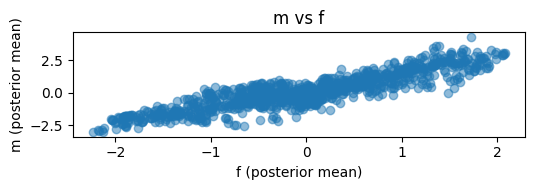

In [356]:
# plot m versus f and m2 versus f 
import matplotlib.pyplot as plt

plt.figure(figsize=(10,2))

plt.subplot(1,2,1)
plt.scatter(m.detach().cpu().numpy(), f.detach().cpu().numpy(), alpha=0.5)
plt.xlabel("f (posterior mean)")
plt.ylabel("m (posterior mean)")
plt.title("m vs f")


plt.tight_layout()
plt.show()


In [357]:
# plot f versus x 
if d==1:
    plt.figure(figsize=(10,2))
    plt.scatter(x.detach().cpu().numpy(), f.detach().cpu().numpy(), alpha=0.5)
    plt.xlabel("x")
    plt.ylabel("f (posterior mean)")
    plt.title("f vs x")
    # plot m versus x 
    # plt.subplot(1,2,2)
    plt.scatter(x.detach().cpu().numpy(), m.detach().cpu().numpy(), alpha=0.5,label="posterior mean")
    plt.xlabel("x")
    plt.ylabel("m (posterior mean)")
    plt.title("m vs x")
    plt.legend()
    plt.tight_layout()
    plt.show()


# M Step

In [358]:
    m_conv = (mtot - 1) // 2
    v_kernel = compute_convolution_vector_vectorized_dD(m_conv, x, h).to(dtype=cdtype)
    toeplitz = ToeplitzND(v_kernel, force_pow2=True)   
    Dprime  = (h**d * kernel.spectral_grad(xis)).to(cdtype)  # (M, 3)
    delta = (q.Delta.to(dtype=cdtype, device=device)).clone()

    # Sigma_z_batch = make_Sigma_z_batch(delta)

    # term1,term2,term3 = m_step(q,m,toeplitz=toeplitz,ws=ws,Dprime=Dprime,J=10,cg_tol=cg_tol,verbose=True,FstarKinv=FstarKinv,fadj_batched=fadj_batched,fwd_batched=fwd_batched)
    cg_tol = 1e-7
    term1,term2,term3 = m_step(q,m,toeplitz=toeplitz,ws=torch.sqrt(kernel.spectral_density(xis)),Dprime=kernel.spectral_grad(xis),J=10,cg_tol=cg_tol,verbose=True,FstarKinv=FstarKinv,fadj_batched=fadj_batched,fwd_batched=fwd_batched,h=h,d=d)
    grad_m = 0.5*(term1 + term2-term3)
    print(term1,term2,term3)

Term I computation time: 0.120s
Term II computation time: 0.205s
  - FstarKinv time: 0.207s
  - Sigma_z time: 0.449s
Term III computation time: 0.000s
Total computation time: 0.325s
tensor([-393.6753,   41.7102]) tensor([-2688.3998,    90.7875]) tensor([-3280.5758,   136.8755])


# Testing

In [359]:
bigger_count = 0
smaller_count = 0
if n<2000:
    F_train = naive_kernel(x, xis)

# Numerically stable version using Cholesky solves and log-determinants
# if x.shape[0]<3000:
def compute_vanilla_gradient(x, y, m, kernel, ws, ws2, F_train, q, jitter=1e-8,Dprime=Dprime):
    """
    Compute vanilla gradient for GP classification using exact kernel matrix.
    
    Args:
        x: input points (n, d)
        y: binary labels (n,)
        m: posterior mean (n,)
        kernel: kernel object with variance and lengthscale
        ws: weights (M,)
        ws2: squared weights (M,)
        F_train: feature matrix (n, M)
        q: variational parameters object
        jitter: numerical stability parameter
        
    Returns:
        tuple: (grad_var, grad_ls, elbo)
    """
    m = m.flatten()
    W_F_train_star = torch.diag(ws) @ F_train.conj().T
    K_train = (F_train * ws) @ W_F_train_star
    
    num_iters = 20

    """
    Returns: (ELBO, grad_var, grad_ls)
    for GP classification ELBO under Poly-Gamma augmentation,
    with manual gradients for kernel.variance and kernel.lengthscale.
    """
    n = x.shape[0]
    device = x.device

    # 1) Precompute things that don't change in the loop
    kappa = y - 0.5                                 # (n,)
    Kff   = F_train @ (torch.diag(ws2.to(dtype=cdtype))) @ F_train.T.conj()
    Kff = Kff.real                     # (n,n)
    D2    = torch.cdist(x, x, p=2).pow(2)            # (n,n)

    # 2) PG variational parameter
    xi = torch.ones(n, device=device)
    m = m.unsqueeze(1).T

    # 3) Fixed-point updates for (m, S)
    for _ in range(1):
        omega = q.Delta

        # build K = Kff + jitter·I
        K = Kff + jitter * torch.eye(n, device=device)
        try:
            L = torch.linalg.cholesky(K, upper=False)
        except RuntimeError:
            # fallback: add more jitter if not positive definite
            K = Kff + (jitter * 10) * torch.eye(n, device=device)
            L = torch.linalg.cholesky(K, upper=False)

        # K⁻¹ via Cholesky (never invert directly)
        I = torch.eye(n, device=device,dtype=rdtype)
        K_inv = torch.cholesky_solve(I, L, upper=False)  # (n,n)

        # S⁻¹ = K⁻¹ + diag(ω)  ⇒  S = (S⁻¹)⁻¹
        S_inv = K_inv + torch.diag(omega)
        try:
            LS = torch.linalg.cholesky(S_inv, upper=False)
        except RuntimeError:
            # fallback: add more jitter if not positive definite
            S_inv = S_inv + (jitter * 10) * torch.eye(n, device=device)
            LS = torch.linalg.cholesky(S_inv, upper=False)
        S = torch.cholesky_inverse(LS, upper=False)  # (n,n)

        # 4) Compute ELBO = E_q[log p(y,f,ω)] − E_q[log q(f,ω)]
        # 4a) likelihood term
        elbo_lik = (kappa * m
                    - 0.5 * omega * (m ** 2 + torch.diagonal(S))
                    - torch.log(torch.tensor(2.0, device=device))).sum()

        # 4b) prior term (use logdet via Cholesky for stability)
        m_col = m.T
        Kinv_m = torch.cholesky_solve(m_col, L, upper=False).squeeze(-1)
        quad = (m * Kinv_m).sum()
        trace_S = torch.trace(torch.cholesky_solve(S, L, upper=False))
        logdet_K = 2.0 * torch.sum(torch.log(torch.diagonal(L)))
        elbo_prior = -0.5 * (quad + trace_S + logdet_K + n * math.log(2 * torch.pi))
        elbo = elbo_lik + elbo_prior

        # 5) Manual gradients
        var = kernel.variance
        ls = kernel.lengthscale

        # ∂K/∂var and ∂K/∂ls
        dK_dvar = F_train @ torch.diag(Dprime[:, 1].to(dtype=cdtype)) @ F_train.T.conj()
        dK_dls = F_train @ torch.diag(Dprime[:, 0].to(dtype=cdtype)) @ F_train.T.conj()

        # helper: v = K⁻¹ m
        v = torch.cholesky_solve(m_col, L, upper=False).squeeze(-1)

        # grad wrt variance
        dK_dvar_r = dK_dvar.to(dtype=rdtype)
        t1var = v @ (dK_dvar_r @ v)
        # Use trace identities for stability, avoid explicit K_inv
        # t2var = tr(K⁻¹ dK K⁻¹ S) = tr((K⁻¹ S) (K⁻¹ dK))
        KinvS = torch.cholesky_solve(S, L, upper=False)
        t2var = torch.sum(KinvS * (K_inv @ dK_dvar_r))
        t3var = torch.sum(K_inv * dK_dvar_r)
        grad_var = 0.5 * (t1var + t2var - t3var)

        # grad wrt lengthscale
        dK_dls_r = dK_dls.to(dtype=rdtype)
        t1 = v @ (dK_dls_r @ v)
        KinvS = torch.cholesky_solve(S, L, upper=False)
        t2 = torch.sum(KinvS * (K_inv @ dK_dls_r))
        t3 = torch.sum(K_inv * dK_dls_r)
        grad_ls = 0.5 * (t1 + t2 - t3)

    t1v1 = t1
    t2v1 = t2
    t3v1 = t3
    elbo1 = elbo

    # ——— 0) Set dtype & device ———
    dtype, device = torch.double, x.device

    # ——— 1) Wrap hyperparams as leaves ———
    var = torch.tensor(kernel.variance,
                    requires_grad=True,
                    dtype=dtype,
                    device=device)
    ls  = torch.tensor(kernel.lengthscale,
                    requires_grad=True,
                    dtype=dtype,
                    device=device)

    # ——— 2) Cast all data to the same dtype/device ———
    x_     = x.to(dtype=dtype, device=device)               # (n,d)
    y_     = y.to(dtype=dtype, device=device).flatten()     # (n,)
    ω      = omega.to(dtype=dtype, device=device).flatten() # (n,)
    m_col  = m.flatten().unsqueeze(-1).to(dtype=dtype, device=device)  # (n,1)

    n = x_.shape[0]

    # ——— 3) Build exact RBF kernel + its inverses ———
    D2    = torch.cdist(x_, x_, p=2).pow(2)              # (n,n)
    base  = torch.exp(-0.5 * D2 / ls.pow(2))             # (n,n)
    K     = var * base + 1e-8 * torch.eye(n, dtype=dtype, device=device)
    L     = torch.linalg.cholesky(K)                     # lower (n,n)
    I     = torch.eye(n, dtype=dtype, device=device)
    K_inv = torch.cholesky_solve(I, L, upper=False)      # (n,n)

    S_inv = K_inv + torch.diag(ω)                        # (n,n)
    LS    = torch.linalg.cholesky(S_inv)                 # (n,n)
    S     = torch.cholesky_inverse(LS, upper=False)      # (n,n)

    # ——— 4) Precompute v = K⁻¹ m ———
    v = torch.cholesky_solve(m_col, L, upper=False)      # (n,1)

    # ——— 5) ∂K/∂var and ∂K/∂ls ———
    dK_dvar = base                                     # (n,n)
    dK_dls  = var * base * D2 / ls.pow(3)              # (n,n)

    # ——— 6) Term 1 = ½·vᵀ (∂K) v ———
    t1_var = (v.T @ (dK_dvar @ v)).squeeze()     # scalar
    t1_ls  = (v.T @ (dK_dls  @ v)).squeeze()     # scalar

    # ——— 7) Term 2 = ½·tr[ S · K⁻¹ (∂K) K⁻¹ ] ———
    tmp_var = K_inv @ dK_dvar @ K_inv                 # (n,n)
    tmp_ls  = K_inv @ dK_dls  @ K_inv                 # (n,n)
    t2_var  =  torch.trace(S @ tmp_var)          # scalar
    t2_ls   = torch.trace(S @ tmp_ls)           # scalar

    # ——— 8) Term 3 = –½·tr[ K⁻¹ (∂K) ] ———
    t3_var =  torch.trace(K_inv @ dK_dvar)      # scalar
    t3_ls  =  torch.trace(K_inv @ dK_dls)       # scalar
    
    return grad_var, grad_ls, elbo1, t1var, t2var, t3var, t1v1, t2v1, t3v1
if n<2000:
    # Call the function
    F_train = naive_kernel(x, xis)
    grad_var, grad_ls, elbo1, t1var, t2var, t3var, t1v1, t2v1, t3v1 = compute_vanilla_gradient(
    x, y, m, kernel, ws, ws2, F_train, q, jitter=1e-4)

    print('##Lengthscale##')
    print(f'My grad## term1 : {term1[0]}, term2: {term2[0]}, term3: {term3[0]}, ')
    # print(f'Manual grad Exact ## : t1_ls: {t1_ls}, t2_ls: {t2_ls}, t3_ls: {t3_ls}')
    print(f'Manual grad Approx: t1v1: {t1v1}, t2v1: {t2v1}, t3v1: {t3v1}, elbo1: {elbo1}')
    print('##Variance##')
    print(f't1var: {term1[1]}, t2var: {term2[1]}, t3var: {term3[1]}')
    # print(f't1_var: {t1_var}, t2_var: {t2_var}, t3_var: {t3_var}')
    print(f't1v1: {t1var}, t2v1: {t2var}, t3v1: {t3var}')
    print('### Grad###')
    print(f'grad_m: {grad_m}')
    print(f'grad_ls: {grad_ls}')
    print(f'grad_var: {grad_var}')
    print('#######')
for _ in range(0):

    m_conv = (mtot - 1) // 2
    v_kernel = compute_convolution_vector_vectorized_dD(m_conv, x, h).to(dtype=cdtype)
    toeplitz = ToeplitzND(v_kernel, force_pow2=True)   
    Dprime  = (h**d * kernel.spectral_grad(xis)).to(cdtype)  # (M, 3)
    # print(Dprime.shape[0])
    delta = (q.Delta.to(dtype=cdtype, device=device)).clone()

    # Sigma_z_batch = make_Sigma_z_batch(delta)

    # term1,term2,term3 = m_step(q,m,toeplitz=toeplitz,ws=ws,Dprime=Dprime,J=10,cg_tol=cg_tol,verbose=True,FstarKinv=FstarKinv,fadj_batched=fadj_batched,fwd_batched=fwd_batched)
    term1,term2,term3 = m_step(q,m,toeplitz=toeplitz,ws=torch.sqrt(kernel.spectral_density(xis)),Dprime=kernel.spectral_grad(xis),J=10,cg_tol=cg_tol,verbose=True,FstarKinv=FstarKinv,fadj_batched=fadj_batched,fwd_batched=fwd_batched,h=h,d=d)
    grad_m = 0.5*(term1 + term2-term3)
    print(term1,term2,term3)




    print('##Lengthscale##')
    print(f'My grad## term1 : {term1[0]}, term2: {term2[0]}, term3: {term3[0]}, ')
    # print(f'Manual grad Exact ## : t1_ls: {t1_ls}, t2_ls: {t2_ls}, t3_ls: {t3_ls}')
    print(f'Manual grad Approx: t1v1: {t1v1}, t2v1: {t2v1}, t3v1: {t3v1}, elbo1: {elbo1}')
    print('##Variance##')
    print(f't1var: {term1[1]}, t2var: {term2[1]}, t3var: {term3[1]}')
    # print(f't1_var: {t1_var}, t2_var: {t2_var}, t3_var: {t3_var}')
    print(f't1v1: {t1var}, t2v1: {t2var}, t3v1: {t3var}')
    print('### Grad###')
    print(f'grad_m: {grad_m}')
    print(f'grad_ls: {grad_ls}')
    print(f'grad_var: {grad_var}')
    print('#######')
        # print("Lengthscale terms (t1, t2, t3):", terms_ls)
        # print("Variance  terms (t1, t2, t3):", terms_var)
    percent_diff = abs((term2[0] - t2v1) / t2v1 * 100)
    if abs(term2[0]) > abs(t2v1):
        print(f"term2[0] magnitude is bigger than t2v1 by {percent_diff:.2f}%")
        bigger_count+=1
    else:
        print(f"term2[0] magnitude is smaller than t2v1 by {percent_diff:.2f}%")
        smaller_count+=1

    print(f"Out of 50 runs:")
    print(f"term2[0] magnitude was bigger than t2v1 {bigger_count} times ({bigger_count/50*100:.1f}%)")
    print(f"term2[0] magnitude was smaller than t2v1 {smaller_count} times ({smaller_count/50*100:.1f}%)")






##Lengthscale##
My grad## term1 : -393.67527069725776, term2: -2688.399849177332, term3: -3280.575751389065, 
Manual grad Approx: t1v1: -393.56234967083117, t2v1: -2277.7473599752448, t3v1: -2600.9486985371695, elbo1: 1965.347394059338
##Variance##
t1var: 41.71021122580724, t2var: 90.78752125711921, t3var: 136.87550718198702
t1v1: 41.70713685411133, t2v1: 84.84007431483734, t3v1: 124.40820847006034
### Grad###
grad_m: tensor([99.2503, -2.1889])
grad_ls: -35.18050555445325
grad_var: 1.0695013494441667
#######


# Output tests

In [367]:
# if n>=2000:
# ----- set up ----------------------------------------------------------
cg_tol      = 1e-6
eps         = 1e-4
trunc_eps   = 1e-1
nufft_eps   = 1e-7

## kernels 
kernel      = SquaredExponential(dimension=d,
                                init_lengthscale=0.4,
                                init_variance =1)

# smaller LR, maximise=True
optimizer   = torch.optim.Adam(kernel._gp_params_ref.parameters(),
                            lr=0.02,
                            maximize=True)


for st in optimizer.state.values():
    st['exp_avg'].zero_();  st['exp_avg_sq'].zero_()


q           = qVariationalParams(n)
lengthscales= []
variances= []

q = qVariationalParams(n)
maxiter=  100
# ----- training loop ---------------------------------------------------
for outer in range(maxiter):                     # “epoch” index
    lengthscales.append(kernel.lengthscale)
    variances.append(kernel.variance)

    # -------- E–STEP (natural gradient) -------------------------------
    # -------- single M–STEP -------------------------------------------
    xis, h, mtot, ws, toeplitz, Dprime, spec_density, spec_grad = setup_spectral_representation(
        x, kernel, eps, trunc_eps,device, rdtype, cdtype)
    
    ws2        = ws.pow(2)

    # FstarKinv = Fstar_Kinv_z_local

    # FstarKinv_vanilla = get_FstarKinv(ws2_vanilla)

    OUT        = (mtot,)*d
    nufft_op   = NUFFT(x, torch.zeros_like(x), h, nufft_eps,
                    cdtype=cdtype, device=device)

    fadj       = lambda v: nufft_op.type1(v, out_shape=OUT).reshape(-1)
    fwd        = lambda fk: nufft_op.type2(fk, out_shape=OUT)
    fadj_batched = vmap(fadj, in_dims=0, out_dims=0)
    fwd_batched = vmap(fwd, in_dims=0, out_dims=0)



    m, Sigma_diags, Sz, probes, q = estep(
        y, q,
        max_iters   = 1,
        rho0        = 0.7,
        gamma       = 1e-3,
        tol         = 1e-6,
        verbose     = (outer == 0 or outer == maxiter-1),  # True for first and last iteration
        J           = 10,
        cg_tol      = cg_tol,
        toeplitz=toeplitz,
        fadj_batched=fadj_batched,
        fwd_batched=fwd_batched,
        ws=ws,
        ws2=ws2
    )

    FstarKinv  = get_FstarKinv(ws2)


    # term1,term2,term3 = m_step(q,m,toeplitz=toeplitz,ws=ws,Dprime=Dprime,J=50,cg_tol=cg_tol,verbose=False,FstarKinv=FstarKinv,fadj_batched=fadj_batched,fwd_batched=fwd_batched)
    term1,term2,term3 = m_step(q,m,toeplitz=toeplitz,ws=torch.sqrt(spec_density),Dprime=spec_grad,J=10,cg_tol=cg_tol,verbose=False,FstarKinv=FstarKinv,fadj_batched=fadj_batched,fwd_batched=fwd_batched,h=h,d=d)

    grad_m = 0.5 * (term1 + term2 - term3)          # ∂ELBO/∂[ℓ, σ²]



    # -------- apply gradient to raw params ----------------------------
    raw        = kernel._gp_params_ref.raw           # unconstrained vector
    pos        = kernel.lengthscale                  # because exp‑transform ⇒ dℓ/draw = ℓ
    raw.grad   = torch.stack([ grad_m[0] * pos,      # length‑scale component
                            grad_m[1] * kernel.variance , torch.tensor(0)])   # variance


    optimizer.step();     optimizer.zero_grad()

    

    # d()
    print(f"iter {outer:3d} | Our Method: ℓ = {kernel.lengthscale:.5f}, σ² = {kernel.variance:.5f} | grad = {grad_m[0].item():+.3e} ")
    # print(f'Term2: {term2[0]}, manual: {t2v1}', 'Term3: ', term3[0], 'manual: ', t3v1)

    # print(f"iter {outer:3d} | Our Method: ℓ = {kernel.lengthscale:.5f}, σ² = {kernel.variance:.5f} | grad = {grad_m[0].item():+.3e} | Vanilla GP: ℓ = {kernel_vanilla.lengthscale:.5f}, σ² = {kernel_vanilla.variance:.5f} | grad = {grad_vanilla[0].item():+.3e}")


Posterior mean time: 0.072s
Hutchinson trace time: 0.101s
it   0  ρ=0.700  max|Δ−Λ|=1.197e-02  time=0.174s
q.Delta[0]: 0.24616180073180738
predictive accuracy (analytic) = 0.6790000200271606
iter   0 | Our Method: ℓ = 0.39208, σ² = 0.98020 | grad = -4.769e+01 
iter   1 | Our Method: ℓ = 0.38437, σ² = 0.98935 | grad = -7.040e+01 
iter   2 | Our Method: ℓ = 0.37700, σ² = 1.00338 | grad = -4.144e+01 
iter   3 | Our Method: ℓ = 0.36967, σ² = 1.01865 | grad = -6.797e+01 
iter   4 | Our Method: ℓ = 0.36243, σ² = 1.03580 | grad = -6.369e+01 
iter   5 | Our Method: ℓ = 0.35529, σ² = 1.05418 | grad = -6.992e+01 
iter   6 | Our Method: ℓ = 0.34838, σ² = 1.07355 | grad = -5.077e+01 
iter   7 | Our Method: ℓ = 0.34155, σ² = 1.09396 | grad = -1.271e+02 
iter   8 | Our Method: ℓ = 0.33481, σ² = 1.11444 | grad = -8.450e+01 
iter   9 | Our Method: ℓ = 0.32812, σ² = 1.13602 | grad = -1.034e+02 
iter  10 | Our Method: ℓ = 0.32155, σ² = 1.15773 | grad = -9.020e+01 
iter  11 | Our Method: ℓ = 0.31517, σ² 

KeyboardInterrupt: 

In [ ]:
lengthscales_vanilla = []
variances_vanilla = []
if n<2000:
    # ----- set up ----------------------------------------------------------
    cg_tol      = 1e-6
    eps         = 1e-4
    trunc_eps   = 1e-1
    nufft_eps   = 1e-7

    ## kernels 
    kernel      = SquaredExponential(dimension=d,
                                    init_lengthscale=0.4,
                                    init_variance =1)
    kernel_vanilla = SquaredExponential(dimension=d,
                                    init_lengthscale=0.4,
                                    init_variance =1)

    # smaller LR, maximise=True
    optimizer   = torch.optim.Adam(kernel._gp_params_ref.parameters(),
                                lr=0.05,
                                maximize=True)
    optimizer_vanilla   = torch.optim.Adam(kernel_vanilla._gp_params_ref.parameters(),
                                lr=0.05, 
                                maximize=True)

    # one‑off: clear any momentum that came from earlier opposite‑sign runs
    for st in optimizer.state.values():
        st['exp_avg'].zero_();  st['exp_avg_sq'].zero_()


    lengthscales= []
    variances= []
    lengthscales_vanilla= []
    variances_vanilla= []
    q = qVariationalParams(n)
    q_vanilla = qVariationalParams(n)
    # ----- training loop ---------------------------------------------------
    for outer in range(50):                     # “epoch” index
        lengthscales.append(kernel.lengthscale)
        variances.append(kernel.variance)
        lengthscales_vanilla.append(kernel_vanilla.lengthscale)
        variances_vanilla.append(kernel_vanilla.variance)
        # -------- E–STEP (natural gradient) -------------------------------
        # -------- single M–STEP -------------------------------------------
        xis, h, mtot, ws, toeplitz, Dprime, spec_density, spec_grad = setup_spectral_representation(
            x, kernel, eps, trunc_eps,device, rdtype, cdtype)
        
        ws2        = ws.pow(2)

        # FstarKinv = Fstar_Kinv_z_local

        # FstarKinv_vanilla = get_FstarKinv(ws2_vanilla)

        OUT        = (mtot,)*d
        nufft_op   = NUFFT(x, torch.zeros_like(x), h, nufft_eps,
                        cdtype=cdtype, device=device)

        fadj       = lambda v: nufft_op.type1(v, out_shape=OUT).reshape(-1)
        fwd        = lambda fk: nufft_op.type2(fk, out_shape=OUT)
        fadj_batched = vmap(fadj, in_dims=0, out_dims=0)
        fwd_batched = vmap(fwd, in_dims=0, out_dims=0)




        m, Sigma_diags, Sz, probes, q = estep(
            y, q,
            max_iters   = 1,
            rho0        = 0.7,
            gamma       = 1e-3,
            tol         = 1e-6,
            verbose     = (outer == 0 or outer == 49),  # True for first and last iteration
            J           = 100,
            cg_tol      = cg_tol,
            toeplitz=toeplitz,
            fadj_batched=fadj_batched,
            fwd_batched=fwd_batched,
            ws=ws,
            ws2=ws2
        )


        xis_vanilla, h_vanilla, mtot_vanilla, ws_vanilla, toeplitz_vanilla, Dprime_vanilla, spec_density_vanilla, spec_grad_vanilla = setup_spectral_representation(
            x, kernel_vanilla, eps, trunc_eps,device, rdtype, cdtype)
        ws2_vanilla = ws_vanilla.pow(2)

        OUT_vanilla        = (mtot_vanilla,)*d

        nufft_op_vanilla   = NUFFT(x, torch.zeros_like(x), h_vanilla, nufft_eps,
                        cdtype=cdtype, device=device)
        fadj_vanilla       = lambda v: nufft_op_vanilla.type1(v, out_shape=OUT_vanilla).reshape(-1)
        fwd_vanilla        = lambda fk: nufft_op_vanilla.type2(fk, out_shape=OUT_vanilla)
        fadj_batched_vanilla = vmap(fadj_vanilla, in_dims=0, out_dims=0)
        fwd_batched_vanilla = vmap(fwd_vanilla, in_dims=0, out_dims=0)

        m_vanilla, Sigma_diags_vanilla, Sz_vanilla, probes_vanilla, q_vanilla = estep(
            y, q_vanilla,
            max_iters   = 1,
            rho0        = 0.7,
            gamma       = 1e-3,
            tol         = 1e-6,
            verbose     = (outer == 0 or outer == 49),  # True for first and last iteration
            J           = 100,
            cg_tol      = cg_tol,
            toeplitz=toeplitz_vanilla,
            fadj_batched=fadj_batched_vanilla,
            fwd_batched=fwd_batched_vanilla,
            ws=ws_vanilla,
            ws2=ws2_vanilla,
        )
        
        # print(f'xis.shape: {xis.shape}')
        # print(f'xis.shape: {xis.shape}')

        # term1, term2, term3 = m_step(
        #     q=q, m=m, toeplitz=toeplitz, Dprime=Dprime,
        #     J       = 10,
        #     cg_tol  = cg_tol,
        #     verbose = False,
        #     FstarKinv = FstarKinv,
        #     fadj_batched=fadj_batched,
        #     fwd_batched=fwd_batched,
        #     ws = ws,
        # )


        FstarKinv  = get_FstarKinv(ws2)


        # term1,term2,term3 = m_step(q,m,toeplitz=toeplitz,ws=ws,Dprime=Dprime,J=20,cg_tol=cg_tol,verbose=False,FstarKinv=FstarKinv,fadj_batched=fadj_batched,fwd_batched=fwd_batched)
        term1,term2,term3 = m_step(q,m,toeplitz=toeplitz,ws=torch.sqrt(kernel.spectral_density(xis)),Dprime=kernel.spectral_grad(xis),J=20,cg_tol=cg_tol,verbose=False,FstarKinv=FstarKinv,fadj_batched=fadj_batched,fwd_batched=fwd_batched,h=h,d=d)

        grad_m = 0.5 * (term1 + term2 - term3)          # ∂ELBO/∂[ℓ, σ²]



        F_train = naive_kernel(x, xis_vanilla)
        grad_var, grad_ls, elbo1, t1var, t2var, t3var, t1v1, t2v1, t3v1 = compute_vanilla_gradient(
        x, y, m_vanilla, kernel_vanilla, ws_vanilla, ws2_vanilla, F_train, q_vanilla,Dprime=Dprime_vanilla, jitter=1e-10
    )
        grad_vanilla= torch.hstack([grad_ls,grad_var,torch.tensor(0)]) 



        # -------- apply gradient to raw params ----------------------------
        raw        = kernel._gp_params_ref.raw           # unconstrained vector
        pos        = kernel.lengthscale                  # because exp‑transform ⇒ dℓ/draw = ℓ
        raw.grad   = torch.stack([ grad_m[0] * pos,      # length‑scale component
                                grad_m[1] * kernel.variance , torch.tensor(0)])   # variance
        


        raw_vanilla        = kernel_vanilla._gp_params_ref.raw           # unconstrained vector
        pos_vanilla        = kernel_vanilla.lengthscale                  # because exp‑transform ⇒ dℓ/draw = ℓ
        raw_vanilla.grad   = torch.stack([ grad_vanilla[0] * pos_vanilla,      # length‑scale component
                                grad_vanilla[1] * kernel_vanilla.variance , torch.tensor(0)])   # variance

        optimizer.step();     optimizer.zero_grad()



        optimizer_vanilla.step(); optimizer_vanilla.zero_grad()
        # d()
        # print(f"iter {outer:3d} | Our Method: ℓ = {kernel.lengthscale:.5f}, σ² = {kernel.variance:.5f} | grad = {grad_m[0].item():+.3e} ")
        # print(f'Term2: {term2[0]}, manual: {t2v1}', 'Term3: ', term3[0], 'manual: ', t3v1)

        print(f"iter {outer:3d} | Our Method: ℓ = {kernel.lengthscale:.5f}, σ² = {kernel.variance:.5f} | grad = {grad_m[0].item():+.3e} | Vanilla GP: ℓ = {kernel_vanilla.lengthscale:.5f}, σ² = {kernel_vanilla.variance:.5f} | grad = {grad_vanilla[0].item():+.3e}")


Posterior mean time: 0.073s
Hutchinson trace time: 0.732s
it   0  ρ=0.700  max|Δ−Λ|=1.139e-02  time=0.809s
q.Delta[0]: 0.24321019457591608
predictive accuracy (analytic) = 0.6790000200271606
Posterior mean time: 0.066s
Hutchinson trace time: 0.661s
it   0  ρ=0.700  max|Δ−Λ|=1.159e-02  time=0.727s
q.Delta[0]: 0.2433980241950017
predictive accuracy (analytic) = 0.6790000200271606
iter   0 | Our Method: ℓ = 0.38049, σ² = 1.05127 | grad = -9.716e+01 | Vanilla GP: ℓ = 0.38049, σ² = 1.05127 | grad = -9.321e+01
iter   1 | Our Method: ℓ = 0.36586, σ² = 1.10454 | grad = -1.722e+01 | Vanilla GP: ℓ = 0.36192, σ² = 1.10522 | grad = -1.016e+02
iter   2 | Our Method: ℓ = 0.35020, σ² = 1.15911 | grad = -8.954e+01 | Vanilla GP: ℓ = 0.34426, σ² = 1.16207 | grad = -1.049e+02
iter   3 | Our Method: ℓ = 0.33465, σ² = 1.21704 | grad = -8.116e+01 | Vanilla GP: ℓ = 0.32751, σ² = 1.22189 | grad = -1.042e+02
iter   4 | Our Method: ℓ = 0.31927, σ² = 1.27602 | grad = -1.125e+02 | Vanilla GP: ℓ = 0.31167, σ² = 1.

KeyboardInterrupt: 

In [170]:
# # Import scikit-learn's Gaussian Process Classifier for automatic hyperparameter learning
# from sklearn.gaussian_process import GaussianProcessClassifier
# from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
# import numpy as np
# import matplotlib.pyplot as plt

# # Create a grid of lengthscale and variance values to evaluate likelihood
# lengthscale_range = np.linspace(0.01, 1, 10)
# variance_range = np.linspace(0.05,2, 5)
# lengthscale_grid, variance_grid = np.meshgrid(lengthscale_range, variance_range)

# # Compute log marginal likelihood for each combination
# log_likelihoods = np.zeros_like(lengthscale_grid)

# for i, ls in enumerate(lengthscale_range):
#     for j, var in enumerate(variance_range):
#         # Create kernel with fixed parameters
#         kernel = C(var, (var, var)) * RBF(length_scale=ls, length_scale_bounds=(ls, ls))
#         gp = GaussianProcessClassifier(kernel=kernel, optimizer=None)  # No optimization
        
#         try:
#             gp.fit(x.reshape(-1, 1), y)
#             log_likelihoods[j, i] = gp.log_marginal_likelihood_value_
#         except:
#             log_likelihoods[j, i] = -np.inf

# # Create 2D plot of likelihood surface
# fig, ax = plt.subplots(figsize=(10, 8))
# contour = ax.contourf(lengthscale_grid, variance_grid, log_likelihoods, levels=20, cmap='viridis')
# ax.contour(lengthscale_grid, variance_grid, log_likelihoods, levels=20, colors='black', alpha=0.3, linewidths=0.5)

# # Add colorbar
# plt.colorbar(contour, ax=ax, label='Log Marginal Likelihood')

# # Plot our method's full optimization path
# n_points = len(lengthscales)
# colors = plt.cm.Blues(np.linspace(0.3, 1.0, n_points))

# # Plot the path with color gradient showing time progression
# for i in range(n_points-1):
#     ax.plot(lengthscales[i:i+2], variances[i:i+2], 
#             color=colors[i], 
#             linewidth=2,
#             alpha=0.8)

# # Plot all points with color gradient
# scatter = ax.scatter(lengthscales, variances, 
#                     c=range(n_points), 
#                     cmap='Blues', 
#                     s=60, 
#                     alpha=0.8,
#                     edgecolors='white',
#                     linewidth=1,
#                     label='PG Method Path')

# # Mark the starting point clearly
# ax.scatter(lengthscales[0], variances[0], 
#           color='blue', 
#           marker='o', 
#           s=200, 
#           label='Start (PG Method)',
#           edgecolor='white',
#           linewidth=2)

# # Mark the ending point clearly
# ax.scatter(lengthscales[-1], variances[-1], 
#           color='darkblue', 
#           marker='*', 
#           s=300, 
#           label='End (PG Method)',
#           edgecolor='white',
#           linewidth=2)

# # Also fit GP with optimization to find the maximum
# kernel_opt = C(1.0, (1e-3, 1e3)) * RBF(length_scale=1.0, length_scale_bounds=(0.1, 10.0))
# gp_classifier = GaussianProcessClassifier(
#     kernel=kernel_opt,
#     optimizer='fmin_l_bfgs_b',
#     n_restarts_optimizer=5,
# )
# gp_classifier.fit(x.reshape(-1, 1), y)

# # Mark the optimized parameters on the plot
# ax.scatter(gp_classifier.kernel_.k2.length_scale, gp_classifier.kernel_.k1.constant_value,
#           color='red', marker='D', s=200, label='Scikit-learn Optimized', edgecolor='white', linewidth=2)

# # Set labels
# ax.set_xlabel('Length Scale')
# ax.set_ylabel('Variance')
# ax.set_title('Log Marginal Likelihood Surface with Optimization Path')

# ax.legend()
# plt.tight_layout()
# plt.show()

# # Print learned hyperparameters
# print("Learned hyperparameters:")
# print(f"Variance (constant kernel): {gp_classifier.kernel_.k1.constant_value:.4f}")
# print(f"Length scale: {gp_classifier.kernel_.k2.length_scale:.4f}")
# print(f"Log marginal likelihood: {gp_classifier.log_marginal_likelihood_value_:.4f}")

# print(f"\nOur method final parameters:")
# print(f"Variance: {variances[-1]:.4f}")
# print(f"Length scale: {lengthscales[-1]:.4f}")
# print(f"Number of iterations: {len(lengthscales)}")


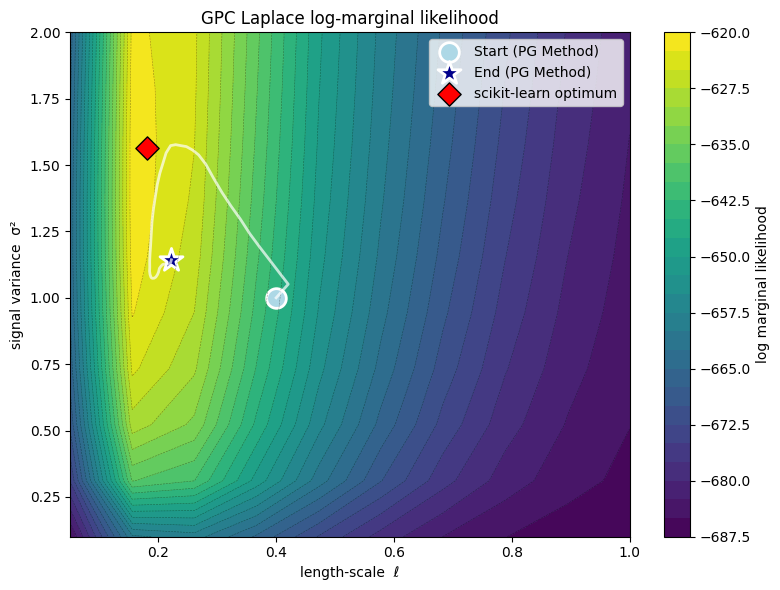

scikit‑learn optimum:
  σ² = 1.5651
  ℓ  = 0.1812  (mean over 2 dims)


In [363]:
    from sklearn.gaussian_process import GaussianProcessClassifier
    from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
    import numpy as np, matplotlib.pyplot as plt


    # --- hyper‑parameter grid ----------------------------------------------------
    lengthscale_range = np.linspace(0.05, 1.0, 10)
    variance_range    = np.linspace(0.1,  2.0, 10)
    ls_grid, var_grid = np.meshgrid(lengthscale_range, variance_range)

    log_lml = np.full_like(ls_grid, -np.inf, dtype=float)

    def make_kernel(ls, var, ndim):
        k = C(var, constant_value_bounds="fixed")
        if ndim == 1:
            k *= RBF(length_scale=ls, length_scale_bounds="fixed")
        else:
            k *= RBF(length_scale=np.full(ndim, ls),
                    length_scale_bounds="fixed")
        return k

    # Subsample data if n is too large
    if x.shape[0] > 2000:
        idx = np.random.choice(x.shape[0], 1000, replace=False)
        x_subset = x[idx]
        y_subset = y[idx]
    else:
        x_subset = x
        y_subset = y

    for i, ls in enumerate(lengthscale_range):
        for j, var in enumerate(variance_range):
            gp = GaussianProcessClassifier(
                kernel=make_kernel(ls, var, d),
                optimizer=None,
                n_jobs=-1,
            )
            try:
                gp.fit(x_subset, y_subset)
                log_lml[j, i] = gp.log_marginal_likelihood_value_
            except Exception:
                pass

    # --- run scikit‑learn's automatic optimisation ------------------------------
    kernel_init = C(1.0, (1e-3, 1e3)) * RBF(length_scale=np.ones(d),
                                            length_scale_bounds=(1e-2, 2.0))
    gp_opt = GaussianProcessClassifier(kernel=kernel_init,
                                    optimizer="fmin_l_bfgs_b",
                                    n_restarts_optimizer=10)
    gp_opt.fit(x_subset, y_subset)

    ls_opt = np.mean(np.atleast_1d(gp_opt.kernel_.k2.length_scale))
    var_opt = gp_opt.kernel_.k1.constant_value

    # --- plot -------------------------------------------------------------------
    fig, ax = plt.subplots(figsize=(8, 6))
    cf = ax.contourf(ls_grid, var_grid, log_lml, 30, cmap="viridis")
    ax.contour(ls_grid, var_grid, log_lml, 30, colors="k", linewidths=0.4, alpha=0.4)
    plt.colorbar(cf, ax=ax, label="log marginal likelihood")

    # Plot optimization path from our method
    ax.plot(lengthscales, variances, 'w-', linewidth=2, alpha=0.7)

    # Mark the starting point
    ax.scatter(lengthscales[0], variances[0],
            color='lightblue',
            marker='o',
            s=200,
            label='Start (PG Method)',
            edgecolor='white',
            linewidth=2)

    # Mark the ending point
    ax.scatter(lengthscales[-1], variances[-1],
            color='darkblue',
            marker='*',
            s=300,
            label='End (PG Method)',
            edgecolor='white',
            linewidth=2)

    ax.scatter(ls_opt, var_opt, marker="D", s=140, c="red",
            label="scikit‑learn optimum", edgecolors="black")
    ax.set_xlabel("length‑scale  ℓ")
    ax.set_ylabel("signal variance  σ²")
    ax.set_title("GPC Laplace log‑marginal likelihood")
    ax.legend()
    plt.tight_layout();  plt.show()

    print("scikit‑learn optimum:")
    print(f"  σ² = {var_opt:.4f}")
    print(f"  ℓ  = {ls_opt:.4f}  (mean over {d} dims)")


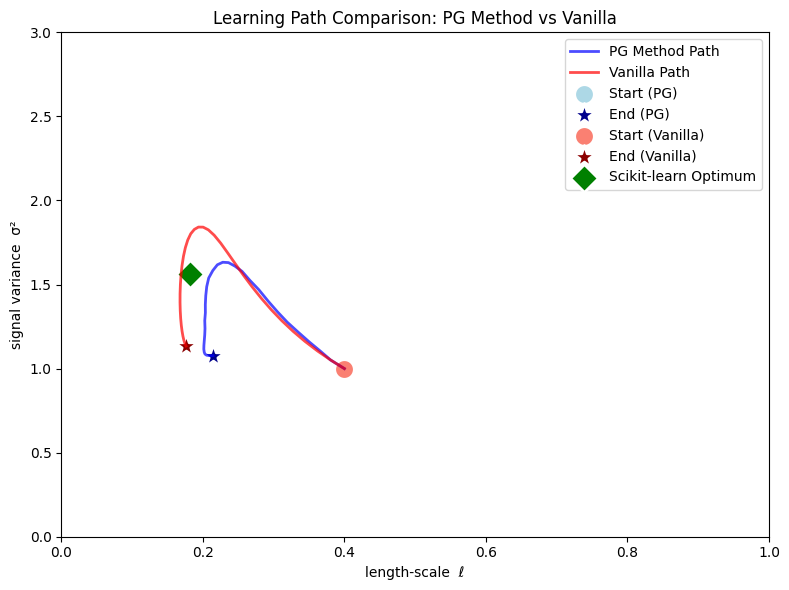

In [370]:
# if n<2000:
# Create a new figure for comparing learning paths
fig, ax = plt.subplots(figsize=(8, 6))
if lengthscales_vanilla is None:
    lengthscales_vanilla = []
    variances_vanilla = []
# Plot our method's path
ax.plot(lengthscales, variances, 'b-', linewidth=2, alpha=0.7, label='PG Method Path')

# Plot vanilla method's path
ax.plot(lengthscales_vanilla, variances_vanilla, 'r-', linewidth=2, alpha=0.7, label='Vanilla Path')

# Mark start/end points for our method
ax.scatter(lengthscales[0], variances[0],
        color='lightblue', 
        marker='o',
        s=200,
        label='Start (PG)',
        edgecolor='white',
        linewidth=2)

ax.scatter(lengthscales[-1], variances[-1],
        color='darkblue',
        marker='*', 
        s=300,
        label='End (PG)',
        edgecolor='white',
        linewidth=2)
ax.set_xlim(0, 1)
ax.set_ylim(0, 3)
# Mark start/end points for vanilla method
if len(lengthscales_vanilla)>0:
    ax.scatter(lengthscales_vanilla[0], variances_vanilla[0],
            color='salmon',
            marker='o',
            s=200, 
            label='Start (Vanilla)',
            edgecolor='white',
            linewidth=2)

    ax.scatter(lengthscales_vanilla[-1], variances_vanilla[-1],
            color='darkred',
            marker='*',
            s=300,
            label='End (Vanilla)',
            edgecolor='white', 
            linewidth=2)
    # Mark scikit-learn optimum
    ax.scatter(ls_opt, var_opt,
            color='green',
            marker='D',
            s=200,
            label='Scikit-learn Optimum',
            edgecolor='white',
            linewidth=2)



ax.set_xlabel("length‑scale  ℓ")
ax.set_ylabel("signal variance  σ²")
ax.set_title("Learning Path Comparison: PG Method vs Vanilla")
ax.legend()
plt.tight_layout()
plt.show()
